# Processing Shipping Data of Danish Ports from Eurostat
*__Python v3.5__*

## Content
- Load required packages
- Make directories
- Download data from Eurostat
- Read input files
- Format dataframe
- Apply traveled distances
- Assign danish regions
- Assign continents
- Transport Supply
- Cargo aggregation
- Apply eca distances
- Long and short distance distinction
- Specific fuel consumption
- ECAs specific transport supply
- ECAs scpecific fuel consumption
- ECAs scpecific co2 emissions
- CO2e budget
- CO2e target
- Plot CO2e budget and targets
- Jet fuel and reduced transport demand

## Script Set-Up

In [1]:
# Required packages
import os
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global plot settings
% matplotlib inline
plt.rcParams.update({'font.size': 30})
plt.rc('legend', fontsize=30)
plt.rcParams['xtick.major.pad'] = '5'
fs = (12, 8)
bw = 0.5

## Make Directories

In [2]:
# Make input and ouput directories
dirs = ['input', 'output']
for i in dirs:
    if not os.path.isdir(i):
        os.makedirs(i)

## Download Data from Eurostat

Description: Gross weight of goods transported to/from main ports - Denmark - annual data

Sources:
1. http://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/mar_go_am_dk.tsv.gz
2. http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=mar_go_am_dk&lang=en


In [3]:
# Download the shipping data from eurostat
url = 'http://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/mar_go_am_dk.tsv.gz'  
filename = 'mar_go_am_dk.tsv.gz'
filepath = os.path.join('input', filename)

if not os.path.exists(filepath):
    urllib.request.urlretrieve(url, filepath)
else:
    print('Using local file from ' + filepath + '.')

Using local file from input\mar_go_am_dk.tsv.gz.


## Read Input Files

### Shipping Data

Referred to as: __*est*__

In [4]:
# Read shipping data to from the filepath to a pandas dataframe
est = pd.read_csv(filepath, sep='\t|\s\t|,', compression='gzip', engine='python', encoding='utf8')

### Cargo Data

Source: http://www.statistikbanken.dk/SKIB72

Referred to as: __*dst*__

In [5]:
# Read cargo data (2015-2016) from csv to a pandas dataframe
dst = pd.read_csv('input/dst_dk_cargo_2015_2016.csv', encoding='utf8')

### Translation Tables

Referred to as: __*trans*__

Source: http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=mar_go_am_dk&lang=en

In [6]:
# Read translation table for Danish port names from input folder
trans_rep = pd.read_csv('input/trans_rep.csv', header=0, encoding='utf8')

In [7]:
# Read translation table for country and region names from input folder
trans_par = pd.read_csv('input/trans_par.csv', sep=',', header=0, encoding='utf8')

In [8]:
# Read translation table for est cargo names from input folder
trans_cargo_est = pd.read_csv('input/trans_cargo_est.csv', sep=',', header=0, encoding='utf8')

In [9]:
# Read translation table for dst cargo names from input folder
trans_cargo_dst = pd.read_csv('input/trans_cargo_dst.csv', sep=',', header=0, encoding='utf8')

In [10]:
# Read translation table for port postcodes from input folder
trans_pp = pd.read_csv('input/trans_portname_postcode.csv', sep=',', header=0, encoding='utf8')

In [11]:
# Read translation table for continent informationfrom input folder
trans_rc = pd.read_csv('input/trans_region_continent.csv', sep=',', header=0, encoding='utf8')

In [12]:
# Create dictionaries from trans tables
rep_dict = trans_rep.set_index('rep_mar')['port_name'].to_dict()
par_dict = trans_par.set_index('par_mar')['region_name'].to_dict()
cargo_est_dict = trans_cargo_est.set_index('cargo_est')['cargo_est_description'].to_dict()
cargo_dst_dict = trans_cargo_dst.set_index('cargo_dst')['cargo_dst_description'].to_dict()

## Distances
Referred to as: __*dis*__

Source: *Alfi Wisdom, MA-Thesis*

In [13]:
# Read distance table for Danish ports and international regions from input folder
dis = pd.read_csv('input/distances_nm.csv', header=0, encoding='utf8')

## Format Data Frame

### Change Data

In [14]:
# Replace colons by nan's
est = est.replace(':', np.nan)

In [15]:
# Rename column names with double meaning
est = est.rename(columns={'rep_mar\\time': 'rep_mar'})

In [16]:
# Change data type of time columns from object to float
est_cols = est.columns.tolist()

for i in est_cols[6:]:
    est[i] = est[i].astype(float)

### Drop Data

In [17]:
# Drop rows that contain the expression 'TOTAL' except for direct
est.drop(est[est[est.columns[1:]].isin(['TOTAL']).any(axis=1)==True].index, inplace=True)

In [18]:
# Drop rows where direct is not 'TOTAL'
est = est[est.direct == 'TOTAL']

In [19]:
# Drop rows where rep_mar is 'DK'
est = est[est.rep_mar != 'DK']

In [20]:
# Filter for countries that are devided into regions. Thus, country data leads to double counting.
country_filter = ['DE', 'UK', 'CA', 'EG', 'ES', 'FR', 'MA', 'RU', 'SE', 'TR', 'US', 'CO', 'MX', 'SA', 'IL']

In [21]:
# Drop countries that are devided to regions
est.drop(est[est.par_mar.isin(country_filter)==True].index, inplace=True)

### Cargo Development

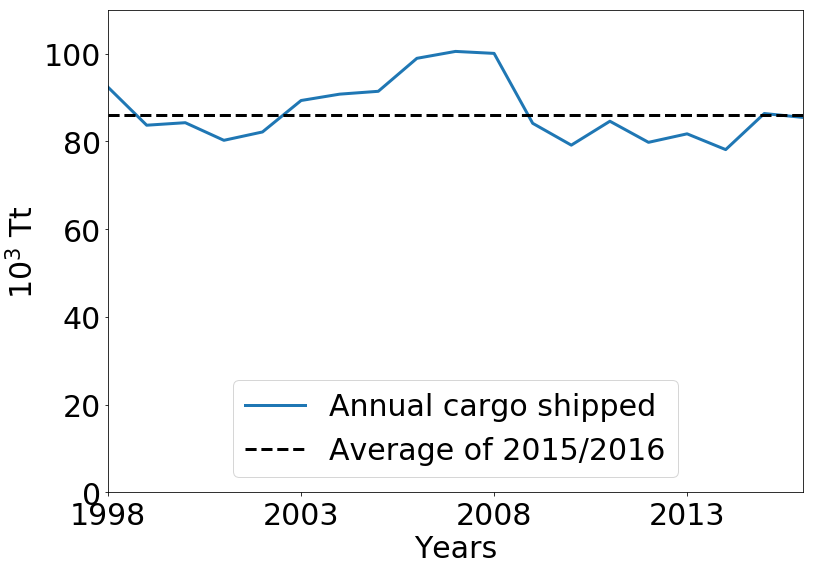

In [22]:
# Plot the summed cargo for all available years
cd = est[est.columns[6:-1]].sum().sort_index(ascending=True) / 1000
cd.plot(figsize=fs, label='Annual cargo shipped', lw=3)#, width=bw)
plt.ylabel('$10^3$ Tt')
plt.axhline(y=cd[-2:].mean(), linestyle='--', color='black', label='Average of 2015/2016', xmin=0, xmax=1, lw=3)
plt.xlabel('Years')
plt.legend(loc=8)
plt.ylim(0, 110)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.savefig('output/cargo_dev.pdf', bbox_inches='tight', compression=None, transparent=True)
plt.show()

### Select Data

In [23]:
# Group by the tables attributes
est_grouped = est.groupby(['par_mar', 'rep_mar', 'cargo', 'unit'])['2016', '2015'].sum()

In [24]:
# Drop rows that contain exclusively nan's
est_grouped.dropna(how='all', inplace=True)

### Calculate Averages

In [25]:
# Create columns for the cargo_aver and sort the data frame by the cargo_aver in descending order
est_grouped['cargo_aver_Tt'] = est_grouped.mean(axis=1)
est_sorted = est_grouped.sort_values('cargo_aver_Tt',  ascending=False)

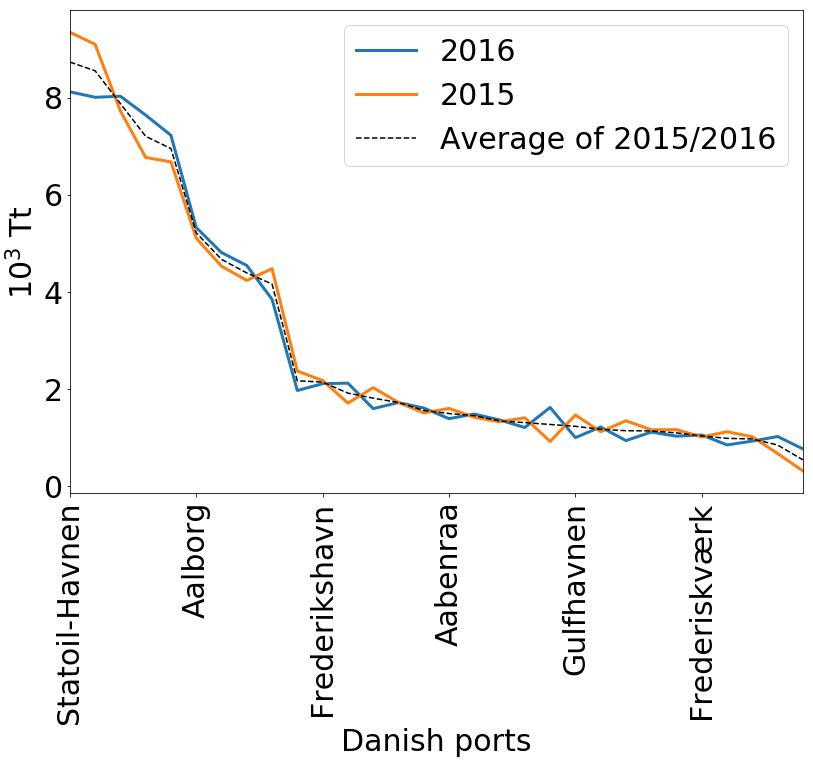

In [26]:
# Plot cargo per port
cpp = est_grouped.reset_index()
cpp.rep_mar.replace(rep_dict, inplace=True)
cpp.rep_mar = cpp.rep_mar.str.split('_', 1).str[0]
cpp = cpp.groupby('rep_mar')[cpp.columns[-3:-1]].sum()
cpp['Average'] = cpp.mean(axis=1)
cpp = cpp.sort_values('Average', ascending=False)
cpp /= 1000
fig, ax = plt.subplots()
cpp.iloc[:, :2].plot(ax=ax, figsize=fs, lw=3)
cpp.iloc[:, -1].plot(ax=ax, figsize=fs, color='black', linestyle='--', label='Average of 2015/2016', legend=True)
plt.ylabel('$10^3$ Tt')
plt.xticks(rotation=90)
plt.legend(loc=1)
plt.tight_layout()
plt.xlabel('Danish ports')
plt.subplots_adjust(bottom=0.1)
plt.savefig('output/cargo_per_port.pdf', bbox_inches='tight', compression=None, transparent=True)
plt.show()

### Translate Data

In [27]:
# Un-group data frame
est = pd.DataFrame(est_grouped)
est.reset_index(inplace=True)

In [28]:
# Apply dictionaries
est['region_int'] = est.par_mar
est.region_int.replace(par_dict, inplace=True)

est['port_dk'] = est.rep_mar
est.port_dk.replace(rep_dict, inplace=True)

est['cargo_type'] = est.cargo
est.cargo_type.replace(cargo_est_dict, inplace=True)

dst['cargo_type'] = dst.cargo
dst.cargo_type.replace(cargo_dst_dict, inplace=True)

## Apply Traveled Distances

In [29]:
# Make a column for distance data
est['distance'] = est.region_int + '|' + est.port_dk

In [30]:
# Re-shape distance data frame
dis = pd.melt(dis,
              id_vars=[dis.columns[0]],
              value_vars=list(dis.columns[1:]),
              var_name='region_int',
              value_name='distance',)

In [31]:
# Convert nautical miles to kilometers
dis.distance *= 1.852

In [32]:
# Consider half of internationsal routes
rows = dis.index[(dis.region_int != 'Denmark')].tolist()
dis.loc[rows].distance *= 0.5

In [33]:
# Make a column that combines international region and danish port
dis['regions_ports'] = dis.region_int + '|' + dis['Travel_From/To']

In [34]:
# Create a dictionary from regions_ports to distances
dis_dict = dis[['distance', 'regions_ports']].set_index('regions_ports')['distance'].to_dict()

In [35]:
# Apply distance dictionary
est.distance.replace(dis_dict, inplace=True)

In [36]:
# Drop rows that have no number in the distance column
est.dropna(how='all', subset=['distance'], inplace=True)
est = est[est.distance.str.isdecimal()!=False]

In [37]:
# Convert distance to float
est.distance = est.distance.astype(float)

## Assign Danish Regions

DKE: Denmark East <br \>
DKW: Denmark West

Postcodes below __5000__ are part of __DKE__, the rest are __DKW__.

In [38]:
# Create dictionarie from trans_pp
pp_dict = trans_pp.set_index('port_name')['postcode'].to_dict()

In [39]:
# Make a danish postcode column
est['postcode_dk'] = est.port_dk.str.split('_').str[0]
dst['postcode_dk'] = dst.port_dk.str.split('_').str[0]

In [40]:
# Apply pp dictionary
est.postcode_dk.replace(pp_dict, inplace=True)
dst.postcode_dk.replace(pp_dict, inplace=True)

In [41]:
# Make a danish region column
est['region_dk'] = est.postcode_dk
dst['region_dk'] = dst.postcode_dk

In [42]:
# Assign region information
est.region_dk = np.where(est.region_dk < 5000, 'DKE', 'DKW')
dst.region_dk = np.where(dst.region_dk < 5000, 'DKE', 'DKW')

## Assign Continents

- africa-north
- africa-south

- america-middle
- america-north
- america- south

- asia-east
- asia-west

- australia

- pacific

In [43]:
# Create dictionarie from trans_rc
rc_dict = trans_rc.set_index('region_int')['continent'].to_dict()

In [44]:
# Apply dictionaries
est['continent'] = est.region_int
est.continent.replace(rc_dict, inplace=True)

## Transport Supply

The annual transport supply is measured in thousand tonne kilometers: $\left[ \frac{Ttkm}{a} \right]$

In [45]:
# Make a new column for the average transport supply [thousand tonne-kilometer]
est['ts_Ttkm'] = est.cargo_aver_Tt * est.distance

In [46]:
# Sort dataframe by the transport supply in descending order
est_sorted = est.sort_values('ts_Ttkm', ascending=False)

In [47]:
# Create a column for cumulative sum of the average
est_sorted['ts_Ttkm_cumsum'] = est_sorted.ts_Ttkm.cumsum()

In [48]:
# Create a column for the cumulative average of the share
est_sorted['ts_Ttkm_cumshare'] = est_sorted.ts_Ttkm_cumsum / est_sorted.ts_Ttkm.sum()

In [49]:
# Cut data frame with a limit in percentage
limit = 1
est_sorted = est_sorted[est_sorted.ts_Ttkm_cumshare <= limit]

In [50]:
# Sort by index data frame
est = est_sorted.sort_index()

## Cargo Aggregation

### EST

In [51]:
# Group by cargo and aggregate the mean distances and the summes of average cargo and Ttkm
cargo_est = est.groupby(['cargo_type']).agg({'distance': 'mean', 'cargo_aver_Tt': 'sum', 'ts_Ttkm': 'sum'}).round(2)

In [52]:
# Calculate the the share of each cargo type
cargo_est['cargo_share'] = cargo_est.cargo_aver_Tt * 100 / cargo_est.cargo_aver_Tt.sum()

In [53]:
# Show data frame
cargo_est

,distance,cargo_aver_Tt,ts_Ttkm,cargo_share
cargo_type,,,,
Dry Bulk,2903.23,22594.0,50132055.15,26.044206
Lq. Bulk,2863.52,33787.0,68611997.78,38.946428
Lrg. Containers,3893.50,5666.5,20996695.34,6.531800
Other,3153.17,3122.5,5341505.06,3.599320
Ro-Ro Non-Self Prop.,661.94,3741.0,2342681.84,4.312268
Ro-Ro Self Prop.,599.58,17841.5,5075664.35,20.565978


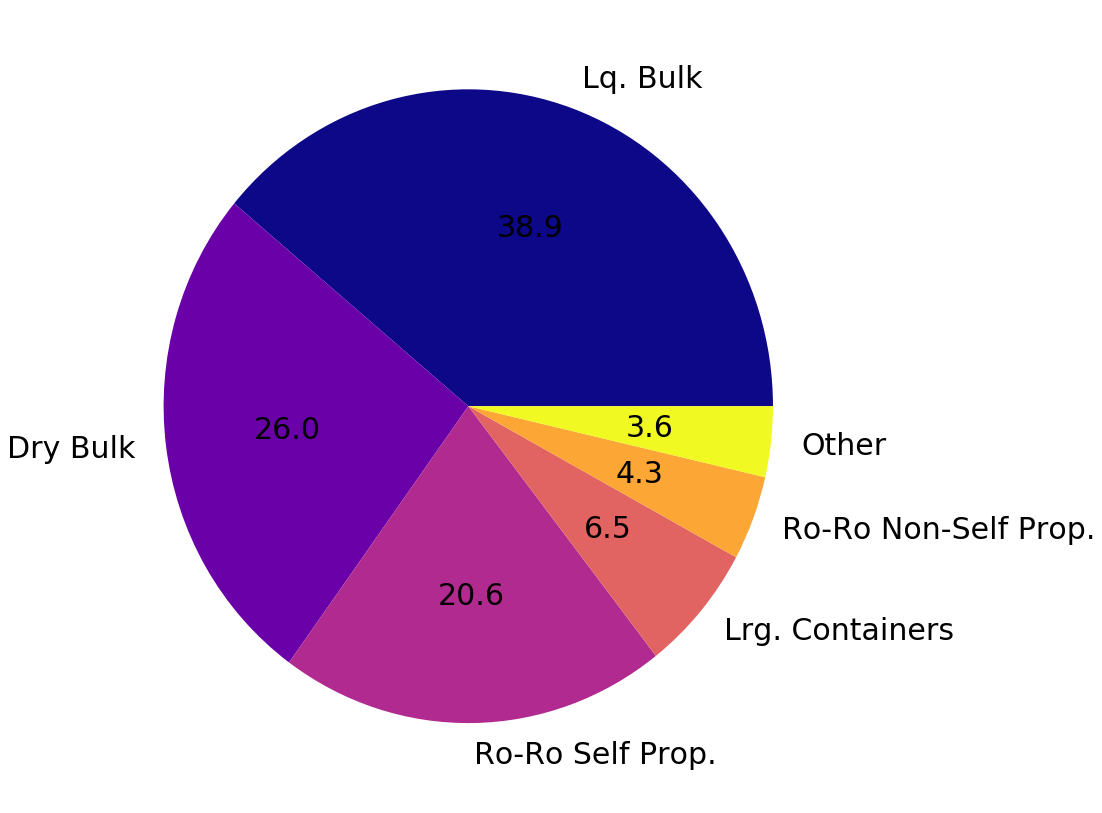

In [54]:
# Plot cargo data from eurostat
cargo_est.cargo_share.sort_values(ascending=False).plot(subplots=True,
                                              kind='pie',
                                              figsize=(12, 12),
                                              colormap='plasma',
                                              autopct='%.1f')
plt.axis('off')
plt.tight_layout()

# Save figure
# plt.savefig('output/eurostat_cargo_share_pie.png', transparent=True)

### DTU Tool
In order to use the dtu calculation tool for emissions, the shares of bulkers, tankers and container ships are needed.

In [55]:
# Shares considering only liquid and dry bulk and larg containers
base = cargo_est.loc[['Dry Bulk', 'Lq. Bulk', 'Lrg. Containers']].cargo_share.sum()
bulker_share = cargo_est.loc['Dry Bulk', 'cargo_share'] / base
tanker_share = cargo_est.loc['Lq. Bulk', 'cargo_share'] / base
containership_share = cargo_est.loc['Lrg. Containers', 'cargo_share'] / base

# Print results
print('bulker: ', round(bulker_share, 2))
print('tanker: ', round(tanker_share, 2))
print('container-ships: ', round(containership_share, 2))

bulker:  0.36
tanker:  0.54
container-ships:  0.09


### DST

In [56]:
# Drop all rows without data
dst = dst.replace(0, np.nan).dropna(how='all', subset=['2015', '2016'])

In [57]:
# Group by danish ports and cargo
dst = dst.groupby(['region_dk', 'cargo_type']).agg({'2015': 'sum', '2016': 'sum'})

In [58]:
# Calculate average of 2015 and 2016
dst['cargo_aver_Tt'] = dst.mean(axis=1)

In [59]:
# Calculate the cargo share for each danish region
dst['cargo_share'] = dst.groupby(level=0).cargo_aver_Tt.transform(lambda x: x * 100 / x.sum())

In [60]:
# Un-group back into a dataframe
dst = pd.DataFrame(dst)
dst.reset_index(inplace=True)

In [61]:
# Group by cargo type and aggregate the cargo average and share
cargo_dst = dst.groupby(['cargo_type']).agg({'cargo_aver_Tt': 'sum', 'cargo_share': 'mean'})

In [62]:
# Apply cargo groupe
cargo_dst['cargo_group'] = cargo_dst.index
cargo_dst['cargo_group'] = cargo_dst['cargo_group'].replace(trans_cargo_dst.set_index('cargo_dst_description')['cargo_group'].to_dict())
cargo_dst['fossil_fuel'] = cargo_dst.index
cargo_dst['fossil_fuel'] = cargo_dst['fossil_fuel'].replace(trans_cargo_dst.set_index('cargo_dst_description')['fossil_fuel'].to_dict())

In [63]:
# Group by cargo group and aggregate the cargo average and share
cargo_dst_grouped = cargo_dst.groupby(['cargo_group']).agg({'cargo_aver_Tt': 'sum', 'cargo_share': 'sum'})
cargo_dst_grouped['Average cargo amount'] = cargo_dst_grouped['cargo_aver_Tt'] / 1000

In [64]:
# Group by cargo_group and fossil fuel and aggregate the cargo average and share
cargo_dst_fossil = cargo_dst
cargo_dst_fossil.cargo_aver_Tt = np.where(cargo_dst_fossil.fossil_fuel=='no', 0, cargo_dst_fossil.cargo_aver_Tt)
cargo_dst_fossil = cargo_dst_fossil.groupby(['cargo_group']).agg({'cargo_aver_Tt': 'sum', 'cargo_share': 'sum'})
cargo_dst_fossil['cargo_share'] = 100 * cargo_dst_fossil['cargo_aver_Tt'] / cargo_dst_grouped['cargo_aver_Tt'].sum() 
cargo_dst_fossil['Fossil share'] = cargo_dst_fossil['cargo_aver_Tt'] / 1000

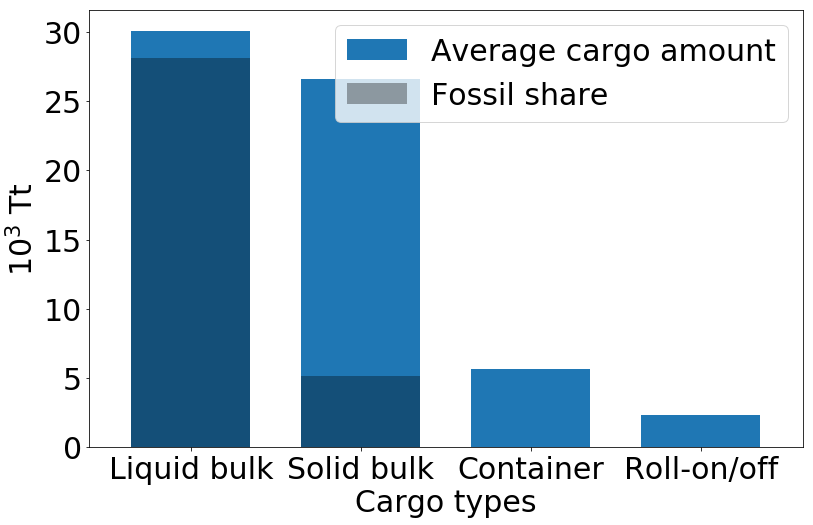

In [65]:
# Plot grouped cargo data from dansk statistics
x = cargo_dst_grouped['Average cargo amount'].sort_values(ascending=False).plot(kind='bar', figsize=fs, width=0.7)
cargo_dst_fossil['Fossil share'].sort_values(ascending=False).plot(x=x, kind='bar', color='black', figsize=fs, width=0.7,
                                                                   alpha=0.33)  # , hatch='////'
plt.xlabel('Cargo types')
plt.legend()
x.set_xticklabels(list(cargo_dst_grouped['Average cargo amount'].sort_values(ascending=False).index), rotation=0)
plt.ylabel('$10^3$ Tt')
plt.tight_layout()
plt.savefig('output/cargo_dst_grouped.pdf', bbox_inches='tight',compression=None, tranparent=True)
plt.show()

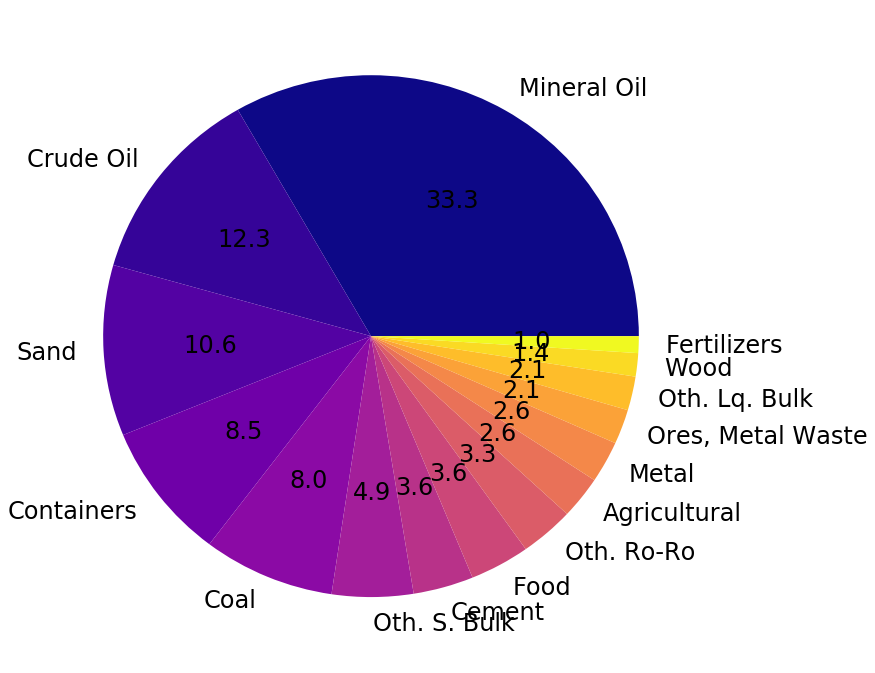

In [200]:
# Plot cargo data from dansk statistics
cargo_dst[cargo_dst.cargo_share > 1].cargo_share.sort_values(ascending=False).plot(subplots=True,
                                                              kind='pie',
                                                              figsize=(12, 12),
                                                              colormap='plasma',
                                                              autopct='%.1f')
plt.axis('off')
plt.rcParams.update({'font.size': 22})

# Save figure
# plt.savefig('output/dst_cargo_share_pie.png', compression=None, transparent=True)

### Continental

In [201]:
# Group by the continent and aggregate the mean distance and the summes of the average cargo and Ttkm
continental2 = est.groupby(['continent']).agg({'distance': 'mean', 'cargo_aver_Tt': 'sum'})

In [202]:
# Group by the continent and aggregate the mean distance and the summes of the average cargo and Ttkm
continental = est.groupby(['continent']).agg({'distance': 'mean', 'cargo_aver_Tt': 'sum', 'ts_Ttkm': 'sum'}).round(2)

In [203]:
# Calculate the the share of each cargo type
continental['ts_Ttkm_share'] = continental.ts_Ttkm * 100 / continental.ts_Ttkm.sum()

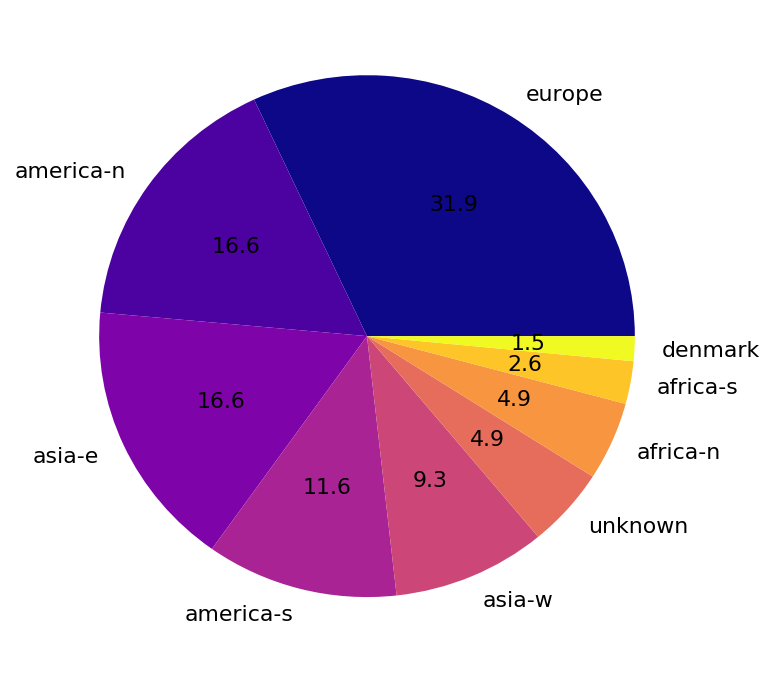

In [204]:
# Plot continental data
continental[continental.ts_Ttkm_share > 1].ts_Ttkm_share.sort_values(ascending=False).plot(subplots=True,
                                                                                           kind='pie',
                                                                                           figsize=(12, 12),
                                                                                           colormap='plasma',
                                                                                           autopct='%.1f')
plt.axis('off')
plt.rcParams.update({'font.size': 22})

# Save figure
# plt.savefig('output/continental_Ttkm_share_pie.png', transparent=True)

## Apply ECA Distances
__*Emission Control Areas*__

### Assumption
- Only __H__eavy __F__uel __O__il (HFO) and __M__arine __D__iesel __O__il (MDO) in use today

- Exclusivly HFO outside the __E__mission __C__ontrol __A__reas (ECAs)

- Exclusivly MDO within the ECAs

- 100 $\%$ ECA countries (ECA100): ['NO', 'SE', 'FI', 'RU_5', 'RU_6', 'EE', 'LV', 'LT', 'PL', 'DE', 'DK', 'NL', 'BE', 'FR', 'UK']

- If not in ECA100 and not america-north: 500 NM within ECA
- If not in ECA100 and in america-north: 500 NM (North Sea) + 250 NM (North America) within ECA

In [205]:
# Filter for countries that routes to and from Denmark are totaly within the ECAs
eca100 = 'NO|SE|FI|RU_5|RU_6|EE|LV|LT|PL|DE|DK|NL|BE|FR|UK'

In [206]:
# Make a new row for the approximate sailing distance within the ECAs
est['distance_eca'] = 500 * 1.852

In [207]:
# Apply 100 percent for eca100 countries
est.loc[est.loc[est.par_mar.str.contains(eca100)==True].index, 'distance_eca'] = est.distance

In [208]:
# Apply US routes distances within ECAs
est.loc[est.loc[est.par_mar.str.contains('US')==True].index, 'distance_eca'] = (500 + 250) * 1.852

In [209]:
# Make a new row for the approximate sailing distance outside the ECAs
est['distance_non_eca'] = est.distance - est.distance_eca

In [210]:
176.7 * est.distance_eca.sum() / est.distance.sum()

53.16606185046385

In [211]:
est.distance_non_eca.sum()

2215254.984000003

In [212]:
est.distance.mean() / 1.852

1571.1046831955969

## Long and Short Distance Distinction

The distinction between long and short distance sailing is determind by the range of full electric cargo vessels.

Assumption: 500 NM (15 knots/h * 35 h)

Source: https://ing.dk/artikel/elektriske-pramme-skal-overtage-lastbilernes-containere-209952


![alt text](https://ing.dk/sites/ing/files/styles/w800_16-9/public/illustration/2018/01/25port-liner-omega-architects1250x704.jpg?itok=M3hd9hbY "Port Liner Concept, Omega Architects")


In [213]:
# Short distance limit
short_limit = 500 * 1.852

In [214]:
short_limit

926.0

In [215]:
# Total transport supply on short distances
ts_short = est.loc[est[est.distance <= short_limit].index, 'ts_Ttkm'].sum()

In [216]:
# Total cargo on short distances
cargo_short = est.loc[est[est.distance <= short_limit].index, 'cargo_aver_Tt'].sum()

In [217]:
# Total transport supply on long distances
ts_long = est.loc[est[est.distance > short_limit].index, 'ts_Ttkm'].sum()

In [218]:
# Total cargo on long distances
cargo_long = est.loc[est[est.distance > short_limit].index, 'cargo_aver_Tt'].sum()

In [219]:
cargo_short / est.cargo_aver_Tt.sum()

0.6349615284862108

### Plot Short and Long Distances

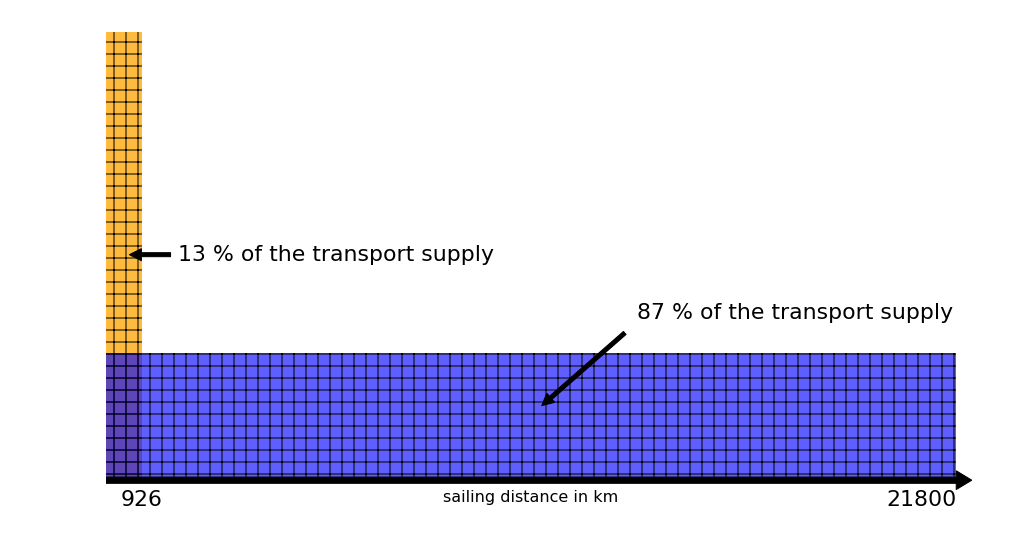

In [220]:
bar_data = (short_limit, est.distance.max())

width_short = (ts_short / est.ts_Ttkm.sum()) / short_limit
width_long = (ts_long / est.ts_Ttkm.sum()) / est.distance.max()
arrow_width = 0.000002

fig, ax = plt.subplots()
short = ax.barh(0, short_limit, width_short, color='orange', alpha=0.75, align='edge', hatch='+')
long = ax.barh(0, est.distance.max(), width_long, color='b', alpha=0.625, align='edge', hatch='+')
ax.axis('off')
ax.annotate('926',
            (short_limit,0 - 2*arrow_width),
            fontsize=22,
            horizontalalignment='center',
            verticalalignment='top')
ax.annotate('sailing distance in km',
            (0.5 * est.distance.max(), 0 - 2*arrow_width),
            fontsize=16,
            horizontalalignment='center',
            verticalalignment='top')
ax.annotate('21800',
            (est.distance.max(), 0 - 2*arrow_width),
            fontsize=22,
            horizontalalignment='right',
            verticalalignment='top')
ax.annotate('13 % of the transport supply',
            xy=(0.5 * short_limit, 0.5 * width_short),
            xytext=(2 * short_limit, 0.5 * width_short),
            arrowprops=dict(facecolor='black', shrink=0.1),
            fontsize=22,
            horizontalalignment='left',
            verticalalignment='center')
ax.annotate('87 % of the transport supply',
            xy=(0.5 * est.distance.max(), 0.5 * width_long),
            xytext=(0.625 * est.distance.max(), 1.25 * width_long),
            arrowprops=dict(facecolor='black', shrink=0.1),
            fontsize=22,
            horizontalalignment='left',
            verticalalignment='bottom')
ax.arrow(0, 0 - (0.5 * arrow_width),
         est.distance.max(), 0,
         width=arrow_width,
         length_includes_head=False,
         color='black',
         head_length=400)
fig.set_size_inches(16, 9)

plt.savefig('output/distances_short_long.pdf', compression=None, transparent=True)

## ECAs Specific Transport Supply
Transport work within (MDO) and outside (HFO) of ECAs in $\left[ Ttkm \right]$

In [221]:
# Make a new column in est for the transport supply within and outside of ecas
est['ts_eca_Ttkm'] = est.distance_eca * est.cargo_aver_Tt
est['ts_non_eca_Ttkm'] = est.distance_non_eca * est.cargo_aver_Tt

In [222]:
# Sum the ecas specific transport supplies and safe the as variables
ts_eca_Ttkm = est.ts_eca_Ttkm.sum()
ts_non_eca_Ttkm = est.ts_non_eca_Ttkm.sum()

# Print results
print('MDO: ', round(ts_eca_Ttkm, 0), ' Ttkm')
print('HFO: ', round(ts_non_eca_Ttkm, 0), ' Ttkm')

MDO:  56363616.0  Ttkm
HFO:  96136983.0  Ttkm


## ECAs Specific Fuel Consumption
Transport work within (MDO) and outside (HFO) of ECAs in $\left[ Ttkm \right]$

Calorific Values:
- MDO - $42.6 \left[ \frac{kJ}{g} \right]$
- HFO - $40.5 \left[ \frac{kJ}{g} \right]$

Sources:
1. Kristenen2012, Tool 2 from raw_data
2. Gilbert2017, p. 856, tab. 1

In [223]:
# A second approach to gain the ecas specific fuel consumption is the product of cargo-distance and
# transport supply. All necessary data comes from Kristenen2012 (Tool 2, raw_data) EuroStat and Wisdom2017
fc_hfo_MJ = ts_non_eca_Ttkm / 0.009685967663109245
fc_mdo_MJ = ts_eca_Ttkm / 0.009403721987628469
fc_PJ = (fc_mdo_MJ + fc_hfo_MJ) / (10**9)

# Print the results
print('2016: MDO -', round(fc_mdo_MJ, 3), 'MJ; HFO -', round(fc_hfo_MJ, 3),'MJ')
print('2016: SUM -', round(fc_PJ, 3),  'PJ')

2016: MDO - 5993756111.692 MJ; HFO - 9925387606.357 MJ
2016: SUM - 15.919 PJ


Side note: Internation Marine Bunkers in 2016 added up to 28 PJ (Enrgy Statistics 2016), including fishery, and military, by definition also cruise ships)

## ECAs Specific CO2e Emissions

In [224]:
# Co2 tank to propeller emissions from Kristenen2012 (Tool 2, raw_data)
# Ch4 tank to propeller emissions from Brynolf2014 and Bengtsson2012
# Ch4 global warming potential factor: 25 (IPCC: https://www.ipcc.ch/publications_and_data/ar4/wg1/en/ch2s2-10-2.html)
co2e_hfo_gMJ = 75.9939941322886 + 0.00045 * 25
co2e_mdo_gMJ = 74.1903973509934 + 0.00045 * 25

In [225]:
# Co2e emissions from Danish shipping on average for 2015/2016 [Mt]
co2e_2016_Mt = (fc_mdo_MJ * co2e_mdo_gMJ + fc_hfo_MJ * co2e_hfo_gMJ) / (10**12)

# Print the result
print(round(co2e_2016_Mt, 4), 'Mt')

1.1991 Mt


## CO2e Budget

The $CO_2$ budget is defined as the amount of $CO_{2eq.}$ emissions that are allowed to be emitted within the Danish maritime cargo sector in order to contribute to a fair extend to staying below a 2 degree surface temperature increase compared to pre-industrial times.

It is derived from the integrated global budget estimate by the IPCC (IPCC WG1 AR5, tab. SPM.3, RCP2.6) and the corresponding share of global maritime cargo transport estimated by the ICCT.

The global shipping CO2e emissions today from the 3rd IMO GHG Study in comparision to the Danish ones deriverd from the EuroStat data and apllied to the ICCT's global budget leads to the Danish CO2e budget.  

- IPCC2013: RCP2.6: __990 Giga tonnes__ (lower limit 510, upper boundary 1505) (http://www.ipcc.ch/pdf/assessment-report/ar5/wg1/WG1AR5_SPM_FINAL.pdf, p.27, tab. SPM.3)
- Olmer2017: __3 %__ (https://www.theicct.org/sites/default/files/publications/Global-shipping-GHG-emissions-2013-2015_ICCT-Report_17102017_vF.pdf, p. 14, tba. 6)
- IMO2014: 3rd GHG Study: __961 Mega tonnes__ (Global shipping CO2e emissions in 2012)
- EuroStat&Wisdom2017: __1.2 Mega tonnes__ (Averg. Danish shipping CO2e emissions 2015-2016)

In [226]:
# Danish share of global maritime co2e emissions
dk_co2e_share = co2e_2016_Mt / 961

# Calculate the CO2eq budget [Mt]
co2e_budget_Mt = 510 * 1000 * 0.03 * dk_co2e_share

# Result
print(round(dk_co2e_share * 100, 4), '% of global shipping emissions')
print(round(co2e_budget_Mt, 2), 'Mt CO2e emissions')
print(int(co2e_budget_Mt / co2e_2016_Mt), 'years left')

0.1248 % of global shipping emissions
19.09 Mt CO2e emissions
15 years left


Side note: Comparing the global transport work of the 3rd IMO GHG Study (Annex 7, p. 256) with the Danish transport work, returns in the same order of magnitude. Approx. 0.05%

## CO2e Target
>### IMO 2050 Target
>- 3.1.3: GHG emissions from international shipping to peak and decline $\Rightarrow \frac{total \ GHG \ emissinos \ (CO2e)}{transport work}$ reduction of __50 % by 2050 compared to 2008__
>- Source: IMO2018, Annex 1, p. 5, 3: LEVELS OF AMBITION AND GUIDING PRINCIPLES

>### Globale CO2e Emissions in 2008
>- CO2e emissions from total shipping in 2008 $\Rightarrow$ __1157 Million tonnes__
>- Source: IMO2014, Executive Summary, p. 1, tab. 1(b): Third IMO GHG Study 2014 CO2e

>### Assumption
>- No change in __transport work__ between 2008 and 2016
>- No change in __Danish shipping share__ between 2008 and 2016

In [227]:
# Imo target for CO2e emissions in 2050
imo_target_Mt = dk_co2e_share * 1157 * 0.5

# Results
print('IMO target in 2050: ', round(imo_target_Mt, 2), ' Mt' )
print('IMO share in 2050: ', round(imo_target_Mt * 100 / co2e_2016_Mt, 1), ' %' )

IMO target in 2050:  0.72  Mt
IMO share in 2050:  60.2  %


## Plot CO2e Budget and Targets

In [228]:
years_2050 = list(range(2016, 2051, 1))
em_2016 = co2e_2016_Mt
eb_550 = co2e_budget_Mt
eb_lin = 0.5 * len(years_2050) * em_2016
eb_imo = 0.5 * ((imo_target_Mt * len(years_2050) / (em_2016 - imo_target_Mt)) + len(years_2050)) * em_2016

em_550 = np.linspace(0, em_2016, int(2*eb_550/em_2016), endpoint=True)[::-1]
em_lin = np.linspace(0, em_2016, int(2*eb_lin/em_2016), endpoint=True)[::-1]
em_imo = np.linspace(0, em_2016, int(2*eb_imo/em_2016)-1, endpoint=True)[::-1]

years_max = list(range(2016, 2016 + len(em_imo) + 1, 1))

In [229]:
em_dk = pd.DataFrame(columns=['RCP2.6',
                     'Linear until 2050',
                     'IMO'], index=years_max)
em_dk.loc[:2016 + len(em_550) - 1, 'RCP2.6'] = em_550
em_dk.loc[:2016 + len(em_lin) - 1, 'Linear until 2050'] = em_lin
em_dk.loc[:2016 + len(em_imo) - 1, 'IMO'] = em_imo

print('RCP2.5: ', round(eb_550, 2), ' Mt')
print('Linear: ', round(eb_lin, 2), ' Mt')
print('   IMO: ', round(eb_imo, 2), ' Mt')

RCP2.5:  19.09  Mt
Linear:  20.98  Mt
   IMO:  52.72  Mt


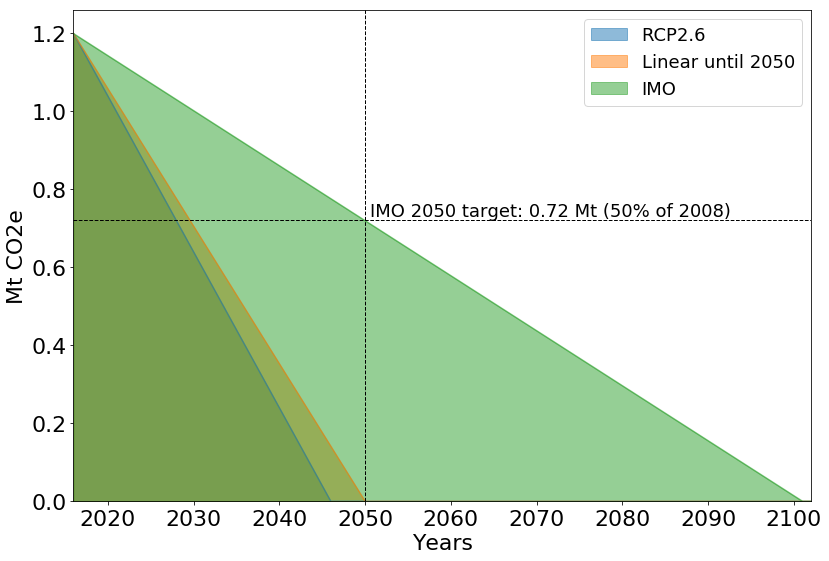

In [230]:
em_dk.plot(kind='area', stacked=False, figsize=fs)  # , colormap='plasma')
plt.ylabel('Mt CO2e')
plt.annotate('IMO 2050 target: {} Mt (50% of 2008)'.format(round(imo_target_Mt, 2)),  # em_dk.loc[2050][2]
            xy=(2050.6, em_dk.loc[2050][2]),
            fontsize=18,
            horizontalalignment='left',
            verticalalignment='upper')
plt.axhline(y=imo_target_Mt, color='black', linestyle='--', lw=1)
plt.axvline(x=2050, color='black', linestyle='--', lw=1)
plt.tight_layout()
plt.xlabel('Years')
plt.subplots_adjust(bottom=0.1)
plt.savefig('output/em_dk_dev.pdf', bbox_inches='tight', compression=None, transparent=True)

## Jet Fuel and Transport Demand Reduction
>A future decreasing transport demand is assumed, due to less use of fossil fuels in the energy sector since many countries drive towards CO2 neutral economies in 2050. Thus, most of the Danish fossil fuel imports and exports can eventually be substituted by renewable alternatives or electricity. However, aviation possibly remains dependet on some sort of mineral product. From today until 2050, fossil fuel cargo is fully taken out, except for the share of jet fuel that is even considered to increase siginfcantly.

### Sources
>- Danich Energy Agency (DEA2018): [oliestatistik 2018](https://ens.dk/sites/ens.dk/files/Statistik/oliestatistik_maanedsstat.xlsx) (https://ens.dk/service/statistik-data-noegletal-og-kort/maanedlig-og-aarlig-energistatistik)
- Neutrium2014: [Energy density of Kerosene](https://neutrium.net/properties/specific-energy-and-energy-density-of-fuels/)
- Mikkel Bosack Simonsen <mibsi@dtu.dk>, DTU Management, Simonsen2018: Denmark jet fuel outlook

#### Simonsen2018: Denmark jet fuel outlook

|Aviation gasoline TRA|Biokerosene TRA|Kerosene TRA|Grand Total [PJ]
:---|---|---|---|---
2015|0.055475|2.104491447|48.70111157|50.86107802
2020|0.0391|6.063232337|50.12143092|56.22376326
2025|0.018951655|11.81513984|48.81029842|60.64438992
2030|0.02219|18.331069|46.70207364|65.05533265
2035|0.006317218|26.15755672|42.26041851|68.42429245
2040||32.76656454|38.96546817|71.73203271
2045||36.71832019|37.68186901|74.4001892
2050||39.29510113|38.12421607|77.4193172

In [231]:
# Energy density of kerosene in PJ per tonnes (Neutrinum2014)
ed_jetfuel_PJ = 46200 / 1000000000

# Amount of jet fuel in the year 2050, converted from PJ to thousand tonnes
cargo_jetfuel_Tt = 50.86107802 / ed_jetfuel_PJ / 1000

# Results
print('Jet fuel in 2015: ', round(cargo_jetfuel_Tt, 1), ' Tt')

Jet fuel in 2015:  1100.9  Tt


In [232]:
# Calculate the transport share of jet fuel
jet_fuel_share = cargo_jetfuel_Tt * 100 / est.cargo_aver_Tt.sum()

# Results
print('Jet Fuel Share in 2015: ', round(jet_fuel_share, 2), ' %')

Jet Fuel Share in 2015:  1.27  %


### Fossil Fuel Share without Jet Fuels

In [233]:
# Calculate the fossil fuel share in 2015/2016, excluding jet fuels
ffs_nj = (cargo_dst_fossil['Fossil share'].sum() - jet_fuel_share) / 100

# Result
print('Fossil Fuel Share without Jet Fuels: ', round(ffs_nj * 100, 2), ' %')

Fossil Fuel Share without Jet Fuels:  32.03  %
